## Obtain scaling factor for laser images

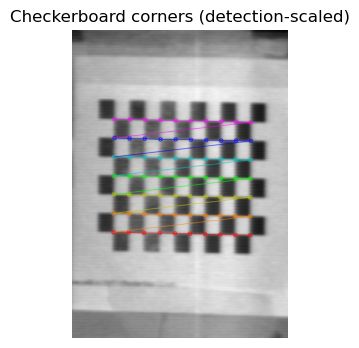

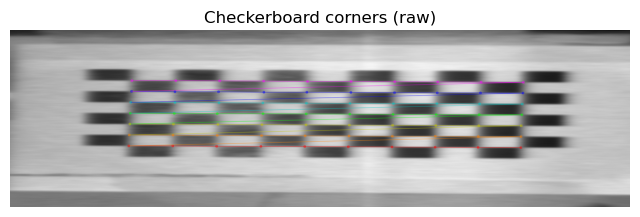

Mean horizontal spacing: -203.56 px
Mean vertical spacing:   -50.66 px
Scaling factor for X axis: 0.2488568276166916


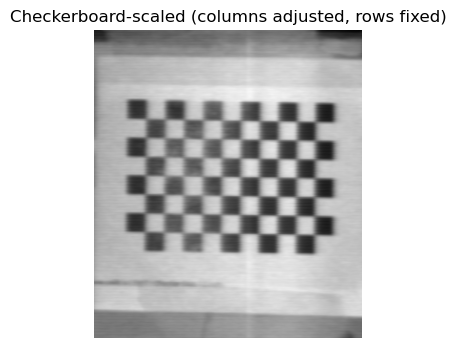

In [63]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pandas as pd

# Load raw laser image of checkerboard and crop field of interest to remove redundant data
img_raw = pd.read_csv(r"K:\ALL\coen\laser\exp1\calibration_laser_1270nm_Dev1_ai1_20251217_145304.csv", delimiter=",", skiprows=4).to_numpy()
img_raw = np.flipud(img_raw)

col_start, col_end = 4200, 7100
img_crop = img_raw[:, col_start:col_end]
rows, cols = img_crop.shape

# Rescale x-axis using visually determined scale factor to prepare image for checkerboard detection
detection_scale_x = 1/5 
scaled_cols = int(cols * detection_scale_x)
img_scaled = cv2.resize(img_crop, (scaled_cols, rows), interpolation=cv2.INTER_AREA)

# Normalize to int for more efficient computation
img_u8 = cv2.normalize(img_scaled, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

# Detect checkerboard 
nx, ny = (10, 7)
pattern_size = (nx, ny)  # inner corners (columns, rows)
ret, corners = cv2.findChessboardCornersSB(img_u8, pattern_size, flags=cv2.CALIB_CB_EXHAUSTIVE)
if not ret:
    raise RuntimeError("Checkerboard detection failed")

# Visualize scaled detection
vis_bgr = cv2.cvtColor(img_u8, cv2.COLOR_GRAY2BGR)
cv2.drawChessboardCorners(vis_bgr, pattern_size, corners, True)
vis_rgb = cv2.cvtColor(vis_bgr, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(8,4))
plt.imshow(vis_rgb)
plt.axis('off')
plt.title("Checkerboard corners (detection-scaled)")
plt.show()

# Remove manual scaling factor and map back to raw coordinates
corners_raw = corners.copy()
corners_raw[:, 0, 0] /= detection_scale_x  

# Visualize raw detection
img_u82 = cv2.normalize(img_crop, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

vis_bgr2 = cv2.cvtColor(img_u82, cv2.COLOR_GRAY2BGR)
cv2.drawChessboardCorners(vis_bgr2, pattern_size, corners_raw, True)
vis_rgb2 = cv2.cvtColor(vis_bgr2, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(8,4))
plt.imshow(vis_rgb2)
plt.axis('off')
plt.title("Checkerboard corners (raw)")
plt.show()

# Calculate scaling factor assuming square checkerboard geometry

# Reshape corners for easier indexing: shape (ny, nx, 2)
corners_grid = corners_raw.reshape((ny, nx, 2))

# Horizontal distances between adjacent corners
dx = np.diff(corners_grid, axis=1)[:,:,0]  # shape (ny, nx-1)
mean_dx = np.mean(dx)

# Vertical distances between adjacent corners
dy = np.diff(corners_grid, axis=0)[:,:,1]  # shape (ny-1, nx)
mean_dy = np.mean(dy)

print(f"Mean horizontal spacing: {mean_dx:.2f} px")
print(f"Mean vertical spacing:   {mean_dy:.2f} px")

# Compute scaling factor for x-axis
scale_x = mean_dy / mean_dx 
print(f"Scaling factor for X axis: {scale_x}")

# Apply scaling factor to x-axis
new_cols = int(cols * scale_x)
img_square_x = cv2.resize(img_crop, (new_cols, rows), interpolation=cv2.INTER_AREA)

# Visualization
img_u8_square = cv2.normalize(img_square_x, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
plt.figure(figsize=(10,4))
plt.imshow(img_u8_square, cmap='gray')
plt.title("Checkerboard-scaled (columns adjusted, rows fixed)")
plt.axis('off')
plt.show()

## Obtain homography (perspective transformation) to align camera and laser images

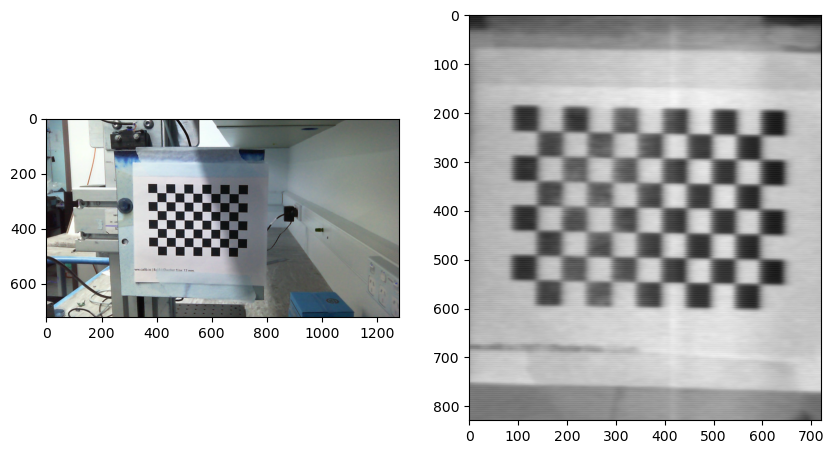

In [65]:
# Load and plot camera image of checkerboard, and rescaled laser image
camera_img = cv2.imread(r"K:\ALL\coen\laser\exp1\calibration.jpg")
laser_img = img_u8_square

fig = plt.figure(figsize=(10, 7))
plt.subplot(1,2,1)
plt.imshow(camera_img)

plt.subplot(1,2,2)
plt.imshow(laser_img, cmap="gray")

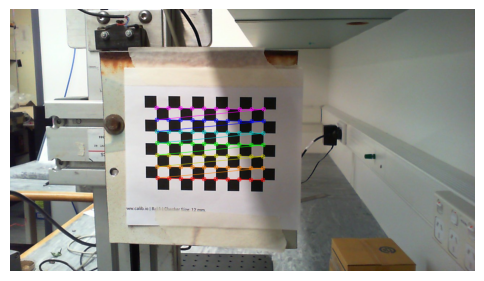

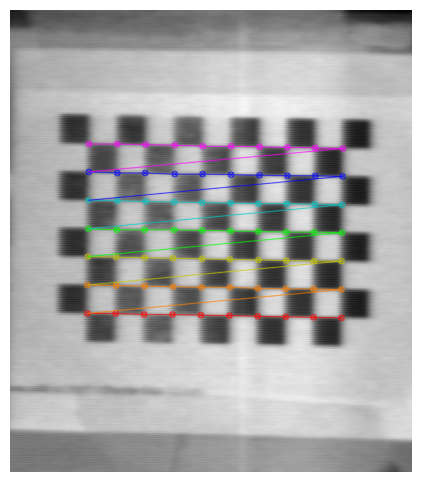

In [69]:
# Detect checkerboard corners in camera and laser image
def Cornerdetector(img):
    ret, corners = cv2.findChessboardCornersSB(
    img,
    pattern_size,
    flags=cv2.CALIB_CB_EXHAUSTIVE)

    assert ret
    corners = corners.reshape(-1, 2)

    # Visualization of detected corners
    vis = img.copy()
    if len(vis.shape)==2:
        vis = cv2.cvtColor(vis, cv2.COLOR_GRAY2BGR)
        
    cv2.drawChessboardCorners(
        vis,
        pattern_size,
        corners,
        True)
    
    # Convert to RGB for matplotlib
    vis_rgb = cv2.cvtColor(vis, cv2.COLOR_BGR2RGB)
    
    plt.figure(figsize=(6,6))
    plt.imshow(vis_rgb)
    plt.axis('off')
    plt.show()
    return corners

camera_corners = Cornerdetector(camera_img)
laser_corners = Cornerdetector(laser_img)

Homography laser to camera:
[[ 6.27795448e-01  3.64147701e-02  3.09215328e+02]
 [-1.29982837e-02  6.61788452e-01  1.17071194e+02]
 [-3.31084362e-05  5.32682997e-05  1.00000000e+00]]


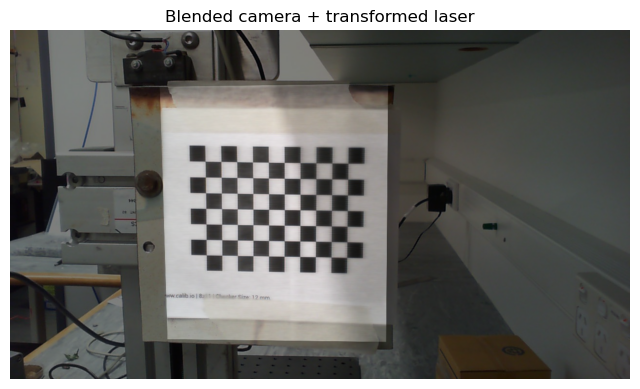

Homography camera to laser:
[[ 1.57591806e+00 -4.76513270e-02 -4.81766764e+02]
 [ 2.18287308e-02  1.53405937e+00 -1.86346012e+02]
 [ 5.05767529e-05 -8.26728105e-05  1.00000000e+00]]


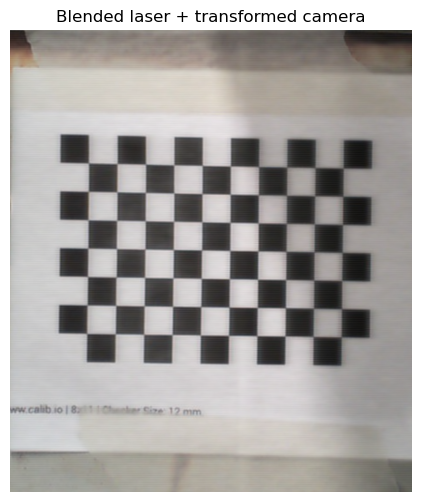

In [74]:
# Calculate and apply homography that aligns checkerboard corners in both images
camera_height, camera_width = camera_img.shape[:2]
laser_height, laser_width = laser_img.shape[:2]

# Laser to camera transformation
H_l2c, _ = cv2.findHomography(laser_corners, camera_corners)
camera_height, camera_width = camera_img.shape[:2]
aligned_laser = cv2.warpPerspective(laser_img, H_l2c, (camera_width, camera_height))

print(f"Homography laser to camera:\n{H_l2c}")

# Visualize alignment in blended image
alpha = 0.5 # 0 = only camera, 1 = only laser
overlay_blend = cv2.addWeighted(cv2.cvtColor(camera_img, cv2.COLOR_BGR2RGB), 1-alpha, cv2.cvtColor(aligned_laser, cv2.COLOR_GRAY2RGB), alpha, 0)

plt.figure(figsize=(8,6))
plt.imshow(overlay_blend)
plt.axis('off')
plt.title("Blended camera + transformed laser")
plt.show()

# Camera to laser transformation
H_c2l, _ = cv2.findHomography(camera_corners, laser_corners)
laser_height, laser_width = laser_img.shape[:2]
aligned_camera = cv2.warpPerspective(camera_img, H_c2l, (laser_width, laser_height))

print(f"Homography camera to laser:\n{H_c2l}")

# Visualize alignment in blended image
alpha = 0.5 # 0 = only laser, 1 = only camera
overlay_blend = cv2.addWeighted(cv2.cvtColor(laser_img, cv2.COLOR_GRAY2RGB), 1-alpha, cv2.cvtColor(aligned_camera, cv2.COLOR_BGR2RGB), alpha, 0)

plt.figure(figsize=(8,6))
plt.imshow(overlay_blend)
plt.axis('off')
plt.title("Blended laser + transformed camera")
plt.show()